In [12]:
import os
import shutil
from pathlib import Path
from random import sample
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils import class_weight
from keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
import keras


# -----------------------------
# Config
# -----------------------------

batch_size = 8
img_height = 256
img_width = 256
original_dir = Path("multi_cancer")          # original dataset
balanced_dir = Path("multi_cancer_balanced") # balanced dataset
target_count = 5000  # desired number of images per class

if balanced_dir.exists():
    shutil.rmtree(balanced_dir)

balanced_dir.mkdir(exist_ok=True)

# -----------------------------
# Step 1: Create balanced dataset
# -----------------------------
balanced_dir.mkdir(exist_ok=True)

for class_folder in original_dir.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name
        print(f"Processing {class_name}...")

        # Create target folder
        dest_folder = balanced_dir / class_name
        dest_folder.mkdir(parents=True, exist_ok=True)

        # List only image files
        files = [f for f in class_folder.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png"]]

        # If more than target_count, randomly select 5000
        if len(files) > target_count:
            files_to_copy = sample(files, target_count)
        else:
            files_to_copy = files  # keep all if <= 5000

        # Copy selected files to new folder
        for f in files_to_copy:
            shutil.copy(f, dest_folder / f.name)

print("Balanced dataset created at:", balanced_dir)

# -----------------------------
# Step 2: Load datasets
# -----------------------------
train_ds = image_dataset_from_directory(
    balanced_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode='grayscale'
)

val_ds = image_dataset_from_directory(
    balanced_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode='grayscale'
)

# Class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

# -----------------------------
# Step 3: Calculate class weights
# -----------------------------
print("Calculating class weights...")

all_labels = []
for class_name in class_names:
    class_path = balanced_dir / class_name
    if class_path.exists():
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_labels.extend([class_names.index(class_name)] * len(files))

all_labels = np.array(all_labels)
classes = np.arange(num_classes)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)
class_weights = dict(zip(classes, class_weights_vals))

# -----------------------------
# Step 4: Print results
# -----------------------------
print("Class counts (approx):", {class_names[i]: np.sum(all_labels == i) for i in classes})
print("Class weights:", class_weights)


Processing breast_benign...
Processing brain_menin...
Processing lung_aca...
Processing breast_malignant...
Processing kidney_tumor...
Processing cervix_dyk...
Processing lung_bnt...
Processing cervix_mep...
Processing brain_tumor...
Processing colon_aca...
Processing kidney_normal...
Processing colon_bnt...
Processing brain_glioma...
Processing lung_scc...
Processing cervix_pab...
Processing cervix_koc...
Balanced dataset created at: multi_cancer_balanced
Found 80000 files belonging to 16 classes.
Using 64000 files for training.
Found 80000 files belonging to 16 classes.
Using 16000 files for validation.
Class names: ['brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt', 'lung_scc']
Calculating class weights...
Class counts (approx): {'brain_glioma': np.int64(5000), 'brain_menin': np.int64(5000), 'brain_tumor': np.int64

In [13]:
from tensorflow.keras.applications import ResNet50

In [14]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

def preprocess_train(image, label):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    x = data_augmentation(image)
    x = preprocess_input(x)
    return x, label

def preprocess_val(image, label):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    x = preprocess_input(image)
    return x, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

# Base model
base_model = ResNet50(
    input_shape=(256, 256, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [15]:
inputs = keras.Input(shape=(256,256,3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.Dropout(0.45)(x)
outputs = keras.layers.Dense(16, activation='softmax', kernel_regularizer=keras.regularizers.l2(1e-4))(x)

model = keras.Model(inputs, outputs)

loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
optimizer = keras.optimizers.Adam(learning_rate=3e-5)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# epochs = 10 
# print("Starting training with class weights...")
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs,
#     callbacks=[early_stop],
#     class_weight=class_weights 
# )

# model.save('cancer_model_weighted.keras')
# print("Model saved to cancer_model_weighted.keras")


In [16]:
class_weights[1] = 2.5
class_weights[9] = 2.5
class_weights[14] = 1.5
class_weights[17] = 1.5
class_weights[3] = 1.5
class_weights[4] = 1.5

In [23]:
# MAKE SURE TO TRAIN AGAIN!

In [17]:
epochs = 5
print("Starting training with class weights...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop],
    # class_weight=class_weights 
)

Starting training with class weights...
Epoch 1/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 1452s 181ms/step - accuracy: 0.9106 - loss: 0.9329 - val_accuracy: 0.9781 - val_loss: 0.7815
Epoch 2/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 1463s 183ms/step - accuracy: 0.9897 - loss: 0.7206 - val_accuracy: 0.9897 - val_loss: 0.7004
Epoch 3/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 1459s 182ms/step - accuracy: 0.9972 - loss: 0.6748 - val_accuracy: 0.9923 - val_loss: 0.6835
Epoch 4/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 1471s 184ms/step - accuracy: 0.9984 - loss: 0.6520 - val_accuracy: 0.9909 - val_loss: 0.6615
Epoch 5/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 1459s 182ms/step - accuracy: 0.9989 - loss: 0.6338 - val_accuracy: 0.9916 - val_loss: 0.6467


In [18]:
from sklearn.metrics import classification_report

y_pred = model.predict(val_ds)  # shape: (num_samples, num_classes)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Concatenate all labels from the dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Convert one-hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)

report = classification_report(y_true_classes, y_pred_classes)
print(report)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1034
           1       0.98      0.95      0.97      1011
           2       0.95      1.00      0.97      1008
           3       0.98      1.00      0.99      1006
           4       1.00      0.98      0.99      1003
           5       1.00      0.99      1.00       977
           6       0.99      1.00      1.00       965
           7       1.00      1.00      1.00      1005
           8       1.00      1.00      1.00      1001
           9       1.00      1.00      1.00      1005
          10       1.00      1.00      1.00      1058
          11       1.00      0.99      0.99      1027
          12       0.99      1.00      0.99       982
          13       1.00      0.99      0.99       993
          14       1.00      1.00      1.00       970
          15       0.99      1.00      0.99       955

    accuracy                     

2026-01-26 16:05:46.504006: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


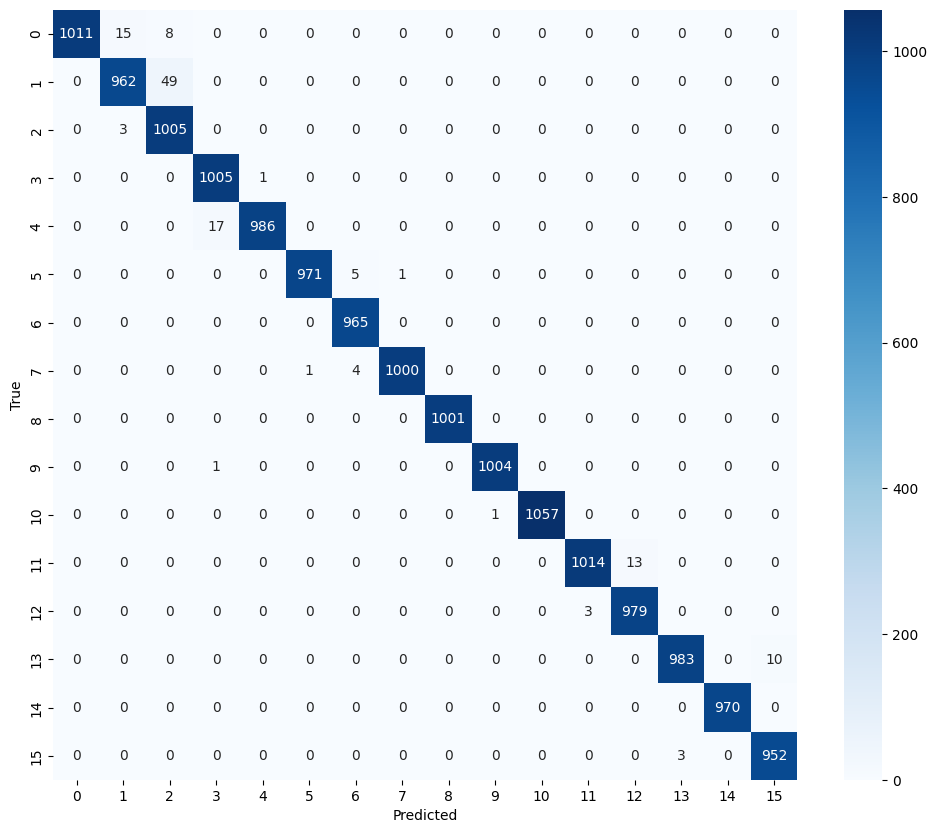

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
class_names

['brain_glioma',
 'brain_menin',
 'brain_tumor',
 'breast_benign',
 'breast_malignant',
 'cervix_dyk',
 'cervix_koc',
 'cervix_mep',
 'cervix_pab',
 'colon_aca',
 'colon_bnt',
 'kidney_normal',
 'kidney_tumor',
 'lung_aca',
 'lung_bnt',
 'lung_scc']

In [22]:
model.save("cancer_model.keras")